# Keras Benchmark 

##### Importing libraries

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from time import time
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,\
    Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
import os
os.chdir('C:/Users/Nicolas/Documents/Data/Faces')

##### Loading all file names

In [51]:
files = glob('combined/*.jpg')
files = np.random.permutation(files)

In [52]:
files[:5]

array(['combined\\35_0_1_20170117095820209.jpg.chip.jpg',
       'combined\\28_0_2_20170116164233720.jpg.chip.jpg',
       'combined\\40_0_3_20170117154652454.jpg.chip.jpg',
       'combined\\36_0_3_20170119201733085.jpg.chip.jpg',
       'combined\\27_0_3_20170119165911975.jpg.chip.jpg'], dtype='<U47')

##### Keeping all correctly formatted labels

In [53]:
np.unique([i[-34] for i in files], return_counts=True)

(array(['0', '1', '9', '_'], dtype='<U1'),
 array([12387, 11316,     1,     5], dtype=int64))

##### Removing problematic target names

In [54]:
faces = [i for i in files if (i[-34] in ('0', '1')) and len(i[-37:-35].strip('\\').strip('d'))  == 2 ]

In [55]:
y = [i[-34] for i in files if (i[-34] in ('0', '1')) and len(i[-37:-35].strip('\\').strip('d')) > 1 ]

In [56]:
sex = ['men', 'women']

In [57]:
assert len(y) == len(faces), 'The X and Y are not of the same length!'

#### This is the shape width/height

In [58]:
dim = 60

#### Cropping function

In [59]:
def crop(img):
    if img.shape[0]<img.shape[1]:
        x = img.shape[0]
        y = img.shape[1]
        crop_img = img[: , int(y/2-x/2):int(y/2+x/2)]
    else:
        x = img.shape[1]
        y = img.shape[0]
        crop_img = img[int(y/2-x/2):int(y/2+x/2) , :]

    return crop_img

##### Loading and cropping images

In [60]:
print('Scaling...', end='')
start = time()
x = []
num_to_load = len(faces)
for ix, file in enumerate(faces[:num_to_load]): 
    image = plt.imread(file, 'jpg')
    image = Image.fromarray(image).resize((dim, dim)).convert('L')
    image = crop(np.array(image))
    x.append(image)
print(f'\rDone. {int(time() - start)} seconds')
y = y[:num_to_load]

Done. 13 seconds


##### Turning the pictures into arrays

In [61]:
x = np.array(x, dtype=np.float32).reshape(-1, 60, 60, 1)
y = np.array(y, dtype=np.float32)
labels = y.copy()

##### Turning the targets into a 2D matrix

In [64]:
y = to_categorical(y, 2)

In [65]:
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [66]:
x.shape, y.shape

((20638, 60, 60, 1), (20638, 2))

In [68]:
assert x.ndim == 4, 'The input is the wrong shape!'

In [69]:
yy, xx = y.nbytes, x.nbytes

In [70]:
print(f'The size of X is {xx:,} bytes and the size of Y is {yy:,} bytes.')

The size of X is 297,187,200 bytes and the size of Y is 165,104 bytes.


In [71]:
files, faces = None, None

##### Displaying the pictures

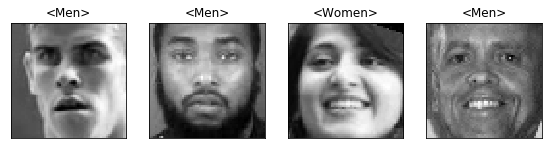

In [72]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 5):
    plt.subplot(1, 5, i)
    rand = np.random.randint(0, x.shape[0])
    ax = plt.imshow(x[rand][:, :, 0], cmap='gray')
    plt.title('<{}>'.format(sex[int(labels[rand])].capitalize()))
    yticks = plt.xticks([])
    yticks = plt.yticks([])

##### Cross-validation

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=2e-1)
x, y = None, None

In [74]:
trainsize, testsize = x_train.shape[0], x_test.shape[0]
print(f'The size of the training set is {trainsize:,} and the '\
     f'size of the test set is {testsize:,}.')

The size of the training set is 16,510 and the size of the test set is 4,128.


##### Scaling, casting the arrays

In [75]:
print('Scaling...', end='')
image_size = x_train.shape[1] * x_train.shape[1] 
x_train = x_train.astype('float32') / 255 
x_test = x_test.astype('float32') / 255
print('\rDone.     ')

Done.     


##### Building the ConvNet

In [77]:
x_train.shape

(16510, 60, 60, 1)

In [78]:
model = Sequential([
    
    Conv2D(16*4, (3, 3), input_shape=(60, 60, 1), activation='relu'),
    MaxPooling2D(),
    
    Conv2D(32*4, (3, 3), activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64*4, (3, 3), activation='relu'),
    MaxPooling2D(),
    
    Conv2D(128*4, (3, 3), activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    
    Dense(1024, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(2, activation='sigmoid')
])

In [79]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 58, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 512)        

##### Compiling the model

In [81]:
model.compile(optimizer=Adam(lr=0.001), 
                             loss='binary_crossentropy', 
                             metrics=['accuracy'])

##### Making callbacks

In [82]:
e_s = EarlyStopping(monitor='val_loss', patience=10)

##### Training the model

In [83]:
hist = model.fit(x_train, y_train,
                 epochs=50,
                 validation_data=[x_test, y_test],
                 batch_size=32,
                 callbacks=[e_s])

Train on 16510 samples, validate on 4128 samples
Epoch 1/50
16510/16510 [==============================] - 194s 12ms/step - loss: 0.4461 - accuracy: 0.7849 - val_loss: 0.3540 - val_accuracy: 0.8445
Epoch 2/50
16510/16510 [==============================] - 189s 11ms/step - loss: 0.3105 - accuracy: 0.8708 - val_loss: 0.3286 - val_accuracy: 0.8685
Epoch 3/50
16510/16510 [==============================] - 187s 11ms/step - loss: 0.2703 - accuracy: 0.8924 - val_loss: 0.2691 - val_accuracy: 0.8939
Epoch 4/50
16510/16510 [==============================] - 184s 11ms/step - loss: 0.2507 - accuracy: 0.8994 - val_loss: 0.2621 - val_accuracy: 0.8960
Epoch 5/50
16510/16510 [==============================] - 179s 11ms/step - loss: 0.2272 - accuracy: 0.9126 - val_loss: 0.2679 - val_accuracy: 0.8979
Epoch 6/50
16510/16510 [==============================] - 178s 11ms/step - loss: 0.2122 - accuracy: 0.9183 - val_loss: 0.2632 - val_accuracy: 0.9006
Epoch 7/50
16510/16510 [==============================] -

##### Evaluating the model

In [84]:
test_loss, test_acc = model.evaluate(x_test, y_test)

4128/4128 [==============================] - 8s 2ms/step


In [85]:
print(f'Test loss: {np.round(test_loss, 4)} — Test accuracy: {int(test_acc*100)}%.')

Test loss: 0.4155 — Test accuracy: 89%.


##### Getting examples of misclassified samples

In [86]:
yy = np.argmax(y_test, axis=1)

In [89]:
xx = np.argmax(model.predict(x_test), axis=1)

In [91]:
wrong_input = x_test[xx != yy]
wrong_target = np.argmax(y_test[xx != yy], axis=1)

In [104]:
assert wrong_input.shape[0] == wrong_target.shape[0], 'Input shape error.'

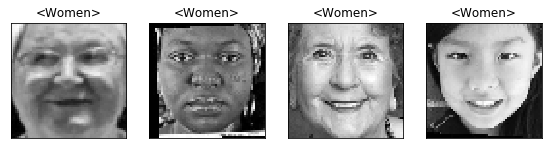

In [99]:
rand = np.random.randint(wrong_target.shape[0])
fig = plt.figure(figsize=(12, 12))
for i in range(1, 5):
    plt.subplot(1, 5, i)
    rand = np.random.randint(wrong_target.shape[0])
    ax = plt.imshow(wrong_input[rand][:, :, 0], cmap='gray')
    plt.title('<{}>'.format(sex[int(wrong_target[rand])].capitalize()))
    yticks = plt.xticks([])
    yticks = plt.yticks([])

The above women were classified as men. It's unclear why.

##### Evolution of the Metrics per Epoch

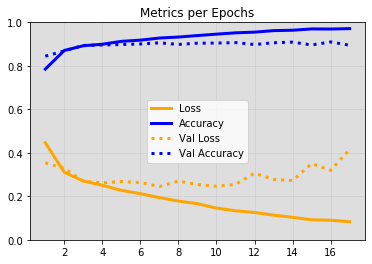

In [103]:
len_epochs = len(hist.history['loss'])
fig, ax = plt.subplots()
ax.set_facecolor('#DEDEDE')
ax.plot(np.arange(1, len_epochs + 1), hist.history['loss'], 
        color='orange', lw=3)
ax.plot(np.arange(1, len_epochs + 1), hist.history['accuracy'], 
        color='blue', lw=3)
ax.plot(np.arange(1, len_epochs + 1), hist.history['val_loss'], 
        color='orange', ls=':', lw=3)
ax.plot(np.arange(1, len_epochs + 1), hist.history['val_accuracy'], 
        color='blue', ls=':', lw=3)
plt.ylim(0, 1)
plt.title('Metrics per Epochs')
plt.legend(['Loss', 'Accuracy', 'Val Loss', 'Val Accuracy'])
plt.grid(True, alpha=.3)
plt.show()

So we reached 90% accuracy. We will do some more work on the Pytorch CNN and get the same accuracy, now that we know that it is possible.